# A4-Q3Q4: DCT and JPEG Compression

In [1]:
import numpy as np
from scipy import fftpack
import copy
import matplotlib.pyplot as plt

## Q3: Discrete Cosine Transform

### Some helper functions

In [2]:
def EvenExtension(f):
    '''
     fe = EvenExtension(f)
     
     Performs an even extension on the array f.
    
     Input:
       f is a 2D array
    
     Output:
       fe is the even extension of f
    
     If f has dimensions NxM, then fe has dimensions
        (2*N-2)x(2*M-2)
     and fe[n,j]=fe[-n,j] for n=0,...,N-1
     and fe[n,j]=fe[n,-j] for j=0,...,M-1
    
     For example, if f is 5x4, then fe has dimensions 8x6.
    
     IEvenExtension is the inverse of EvenExtension, so that
        IEvenExtension(EvenExtension(f)) == f
     for any matrix f.
    
    '''

    fe = np.concatenate((f,np.fliplr(f[:,1:-1])), axis=1)
    fe = np.concatenate((fe, np.flipud(fe[1:-1,:])), axis=0)
    return fe

def IEvenExtension(fe):
    '''
     f = IEvenExtension(fe)
    
     Reverses the action of an even extension.
    
     Input:
       fe is a 2D array, assumed to contain an even extension
    
     Output:
       f is the sub-array that was used to generate the extension
    
     If fe has dimensions KxL, then f has dimensions
        ceil((K+1)/2) x ceil((L+1)/2)
     For example, if fe is 8x6, then f is 5x4.
    
     IEvenExtension is the inverse of EvenExtension, so that
        IEvenExtension(EvenExtension(f)) == f
     for any matrix f.
    
    '''

    e_dims = np.array(np.shape(fe))
    dims = np.ceil((e_dims+1.)/2)
    dims = np.array(dims, dtype=int)
    f = fe[:dims[0], :dims[1]]
    return f

In [3]:
# Define a simple 2-D array to play with
f = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]], dtype=float)
print(f)

[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]]


In [4]:
# Even extension
fe = EvenExtension(f)
print(fe)

[[ 1.  2.  3.  4.  3.  2.]
 [ 5.  6.  7.  8.  7.  6.]
 [ 9. 10. 11. 12. 11. 10.]
 [ 5.  6.  7.  8.  7.  6.]]


In [5]:
# Check that it's even, if you don't believe me
n = np.random.randint(np.shape(f)[0])
j = np.random.randint(np.shape(f)[1])
print((n,j))
print(fe[n,j])
print(fe[-n,-j])

(1, 2)
7.0
7.0


In [6]:
# Inverse even extension
g = IEvenExtension(fe)
print(g)

[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]]


### `myDCT`

In [7]:
def myDCT(f):
    '''
     Fdct = myDCT(f)
    
     Computes the 2-D Discrete Cosine Transform of input image f.
     It uses an even extension of f, along with the 2D-DFT.
     This function is the inverse of myIDCT.
    
     Input:
      f is a 2-D array of real values
    
     Output:
      Fdct is a real-valued array the same size as f
    '''

    # YOUR CODE HERE
    
    # deepcopy f to f_s
    f_s = copy.deepcopy(f)
    
    # extend f_s evenly to get a complete period of g
    g = EvenExtension(f_s)
    
    # compute 2d-dft of g
    G = np.fft.fft2(g)
    
    # get the first N coefficients
    G_P = copy.deepcopy(G[0: len(f[:, 0]), 0: len(f[0])])
    
    
    
    return G_P

### `myIDCT`

In [8]:
def myIDCT(Fdct):
    '''
     f = myIDCT(Fdct)
    
     Computes the 2-D Inverse Discrete Cosine Transform (IDCT) of input
     array Fdct. It uses an even extension of Fdct, along with the 2D-IDFT.
     This function is the inverse of myDCT.
    
     Input:
      Fdct is a 2-D array of real values
    
     Output:
      f is a real-valued array the same size as Fdct
    '''

    # deepcopy Fdct to G_s
    G_s = copy.deepcopy(Fdct)
    
    # extend G_s evenly to get a complete period of G
    G = EvenExtension(G_s)
    
    # compute 2d-idft of G
    g = np.fft.ifft2(G)
    
    # get the first N coefficients
    f = IEvenExtension(g)
    
    return f

## Q4: JPEG Compression

In [10]:
# A couple functions to help you
def NumPixels(f):
    '''
     n = NumPixels(f) returns the total number of elements in the array f.
     
     For example,
       NumPixels( np.ones((5,4)) )
     returns the value 20.
    '''
    return np.prod(np.shape(f))

def Show(g, title=''):
    '''
     Show(g, title='')
     
     Displays the image g as a graylevel image with intensities
     clipped to the range [0,255].
    '''
    plt.imshow(np.clip(g, a_min=0, a_max=255), cmap='gray');
    plt.axis('off');
    plt.title(title);

### `myJPEGCompress`

In this question, we extract low-frequency coefficients from each T×T coefficient array by keeping the left-top-most part (i.e. the first D×D subarray) of the array. The reason is because according to the lecture note, DFT has low-frequency coefficients at the beginning and the end, and since DCT only keeps half of a whole period and is even (if we extend it), we know only the coefficients at the beginning correspond to low frequency, and the coefficients at the end correspond to high frequency.

In [21]:
def myJPEGCompress(f, T, D):
    '''
     G = myJPEGCompress(f, T, D)
    
     Input
        f is the input image, a 2D array of real numbers
        T is the tile size to break the input image into
        D is the size of the block of Fourier coefficients to keep
          (Bigger values of D result in less loss, but less compression)
    
     Output
        G is the compressed encoding of the image
    
     Example: If f is 120x120, then
    
        G = myJPEGCompress(f, 10, 4)
    
     would return an array (G) of size 48x48.
    '''
    
    G = f # YOUR CODE HERE
    
    # break up the image into T-by-T tiles
    j = 0  # tracks the y-axis
    hor_len = len(f[0])  # length of the image
    ver_len = len(f[:, 0])  # height of the image
    tiles = []    # array used store divided tiles of DCT representations
    
    # compute DCT for each T-by_T tile
    while j + T <= ver_len:
        i = 0  # tracks the x-axis
        
        while i + T <= hor_len:
            sub = np.zeros((T, T), dtype=np.float)  # store the image tile
            sub = G[j: j + T, i: i + T]  # locate to the correct tile of image and assign it to sub
            
            sub_DCT = myDCT(sub)  # get the DCT coefficient of the image tile
            
            extr_sub_DCT = np.zeros((D, D), dtype = np.float)  # store the D-by-D subarray of sub_DCT
            extr_sub_DCT = sub_DCT[0: D, 0: D]  # the left-top part of D-by-D area is the low-frequency coefficients
            
            tiles.append(extr_sub_DCT)
            
            i += T
            
        j += T
              
    # combine the tiles of representation
    y = 0  # tracks the y-axis
    length = len(tiles)
    ver_pic = int(ver_len / T)  # how many pieces of tiles in each column
    hor_pic = int(hor_len / T)  # how many pieces of tiles in each row
    G = np.zeros((ver_pic * D, hor_pic * D), dtype=np.float)  # stores representation
    while y < ver_pic:
        x = 0  # tracks the x-axis
        while x < hor_pic:
            G[y * D: y * D + D, x * D: x * D + D] = tiles[y * hor_pic + x]
            x += 1
        y += 1
    

    return G

### `myJPEGDecompress`

In [22]:
def myJPEGDecompress(G, T, D):
    '''
     f = myJPEGDecompress(G, T, D)
    
     Input
        G is the compressed encoding, a 2D array of real numbers
        T is the tile size for reassembling the decompressed image
        D is the size of the blocks of Fourier coefficients that were
          kept when the image was compressed
          (Bigger values of D result in less loss, but less compression)
    
     Output
        f is the decompressed, reconstructed image
    
     Example: If G is 48x48, then
    
        f = myJPEGDecompress(G, 10, 4);
    
     would return an array (f) of size 120x120.
    '''
    
    f = G # YOUR CODE HERE
    
    j = 0  # tracks the y-axis
    hor_len = len(G[0])  # length of the representation
    ver_len = len(G[:, 0])  # height of the representation
    tiles = []    # array used store divided representation tiles
    
    # divide representation into tiles
    while j + D <= ver_len:
        i = 0  # tracks the x-axis
        
        while i + D <= hor_len:
            sub = np.zeros((T, T), dtype=np.float)  # store the tile
            
            # Embed the D × D array of DCT coefficients into a T × T array of zeros
            sub[0: D, 0: D] = f[j: j + D, i: i + D]

            
            # do IDCT to the T-by-T tile
            sub_IDCT = myIDCT(sub)

            
            tiles.append(sub_IDCT)
            
            i += D
        j += D
        
        
    # combine the tiles into one image
    y = 0  # tracks the y-axis
    length = len(tiles)  # how many tiles do we have
    ver_pic = int(ver_len / D)  # how many pieces of tiles in each column
    hor_pic = int(hor_len / D)  # how many pieces of tiles in each row
    f = np.zeros((ver_pic * T, hor_pic * T), dtype=np.float)  # stores the decompressed image
    while y < ver_pic:
        x = 0  # tracks the x-axis
        while x < hor_pic:
            f[y * T: y * T + T, x * T: x * T + T] = tiles[y * hor_pic + x]
            x += 1
        y += 1
        
    return f

### Demonstrate Compression

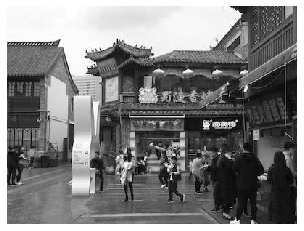

In [13]:
f = plt.imread('Jinan.jpg')[:,:,0]
Show(f)

The compression ratio is 4.340277777777778


D:\滑铁卢大学\ArcGIS\ArcGIS\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
D:\滑铁卢大学\ArcGIS\ArcGIS\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:59: ComplexWarning: Casting complex values to real discards the imaginary part


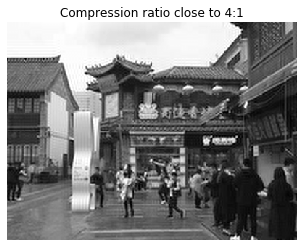

In [23]:
# Compression ratio close to 4:1:
G = myJPEGCompress(f, 25, 12)
compressed_f = myJPEGDecompress(G, 25, 12)
Show(compressed_f, title = 'Compression ratio close to 4:1')
print("The compression ratio is " + str(NumPixels(f) / NumPixels(G)))

The compression ratio is 9.765625


D:\滑铁卢大学\ArcGIS\ArcGIS\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
D:\滑铁卢大学\ArcGIS\ArcGIS\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:59: ComplexWarning: Casting complex values to real discards the imaginary part


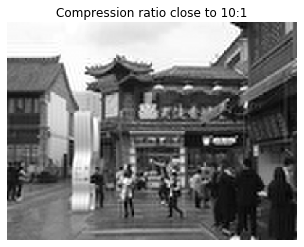

In [24]:
# Compression ratio close to 10:1:
G = myJPEGCompress(f, 25, 8)
compressed_f = myJPEGDecompress(G, 25, 8)
Show(compressed_f, title = 'Compression ratio close to 10:1')
print("The compression ratio is " + str(NumPixels(f) / NumPixels(G)))

The compression ratio is 25.0


D:\滑铁卢大学\ArcGIS\ArcGIS\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
D:\滑铁卢大学\ArcGIS\ArcGIS\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:59: ComplexWarning: Casting complex values to real discards the imaginary part


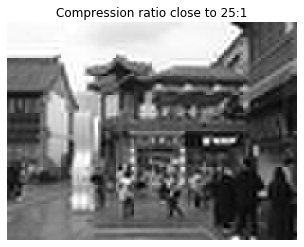

In [25]:
# Compression ratio close to 4:1:
G = myJPEGCompress(f, 25, 5)
compressed_f = myJPEGDecompress(G, 25, 5)
Show(compressed_f, title = 'Compression ratio close to 25:1')
print("The compression ratio is " + str(NumPixels(f) / NumPixels(G)))